<a href="https://colab.research.google.com/github/dolmani38/drift/blob/main/synthetic_data_generation_1112.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
if True:
    from google.colab import drive
    drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
import os

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

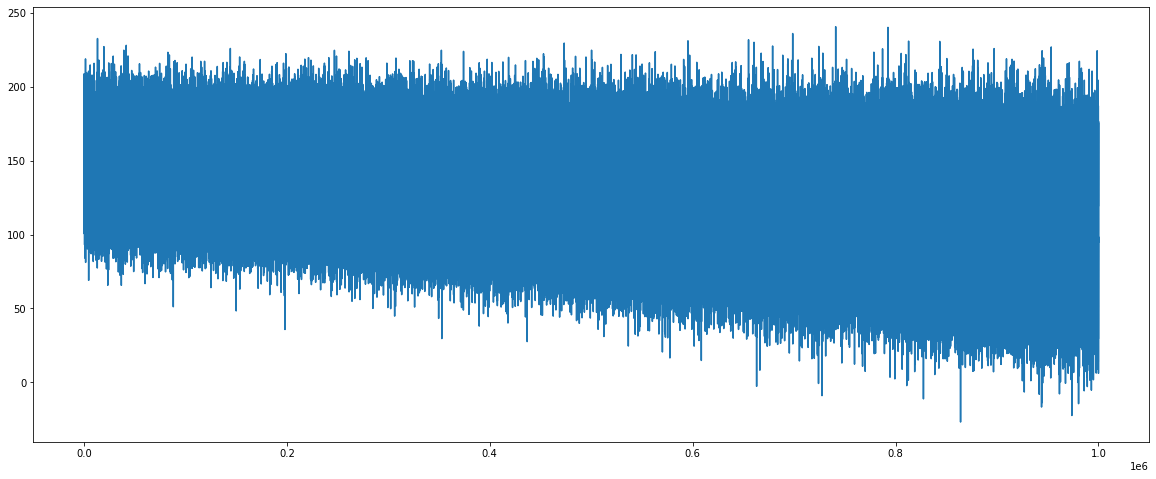

In [293]:
import random

data_x = {}
weight = {}
errors = []
for f in range(10):
    data_x[f'x{f}'] = []
    weight[f'w{f}'] = []
    d1 = random.uniform(0.5, 10.0)
    d2 = random.uniform(0.0, 0.001)
    d3 = random.uniform(0.0, 0.003)
    w = random.uniform(0, 5)
    w_delta = random.uniform(-0.003, 0.001)
    for i in range(1000):
        for j in range(10):
            data_x[f'x{f}'].extend(np.random.normal(d1+(i*d2),2.0+(i*d3),100))
            weight[f'w{f}'].extend(w + (w_delta*i)+np.random.normal(0.0,0.01,100))
            #weight[f'w{f}'].extend(w + np.random.normal(0.0,0.01,100))

for i in range(10000):        
    errors.extend(np.random.normal(1.0,10.0,100))

dataset = pd.DataFrame(data_x)
importance = pd.DataFrame(weight)

y=np.sum(np.multiply(importance.values,dataset.values),axis=1) + np.asarray(errors)

plt.figure(figsize=(20,8))
plt.plot(y)

In [294]:
dataset['y'] = [1 if i > 100 else 0 for i in y]

In [295]:
dataset

,x0,x1,x2,x3,x4,x5,x6,x7,x8,x9,y
0,10.590042,12.738756,8.310131,8.305769,3.229418,-3.942770,6.063200,3.382825,1.385873,5.325389,1
1,11.189313,11.788657,11.850584,9.795924,5.344567,-0.125656,4.468247,8.305370,0.677616,4.065052,1
2,6.753590,12.557823,9.784451,8.416434,6.452788,-1.804386,1.890510,8.021134,-0.113777,7.485644,1
3,10.765344,8.745254,9.929067,5.055283,4.538009,2.169646,7.223936,10.246935,1.134293,8.420375,1
4,10.367308,6.872974,9.348114,5.614638,5.441261,-0.446490,6.864472,9.464455,-0.358331,7.238884,1
...,...,...,...,...,...,...,...,...,...,...,...
999995,8.657791,9.773810,7.380989,5.615801,8.250041,3.151175,4.412066,4.234590,0.876878,7.653139,0
999996,12.521929,10.747742,0.158400,7.218412,2.161350,-3.779854,6.184458,5.719899,-0.128492,9.665210,0
999997,8.659944,14.057433,8.791565,7.430962,9.282948,-2.765400,2.454961,8.714085,2.864593,9.652508,0
999998,10.891562,4.834380,14.014475,7.848189,1.981109,7.664293,7.079034,9.331963,4.703376,8.160679,1


In [281]:
dataset.to_csv('/content/drive/MyDrive/laos/synthetic_dataset_1.csv')

In [15]:
from sklearn.ensemble import RandomForestClassifier

In [316]:
trainset = dataset[0:100000].drop(columns=['y']).values
train_y = dataset[0:100000]['y'].values

In [317]:
business_model = RandomForestClassifier(n_estimators=80,max_depth=5)
business_model.fit(trainset,train_y)

RandomForestClassifier(max_depth=5, n_estimators=80)

In [318]:
testset = dataset[100000:110000].drop(columns=['y']).values
test_y = dataset[100000:110000]['y'].values

In [319]:
from sklearn.metrics import precision_recall_fscore_support

base_score = precision_recall_fscore_support(test_y, business_model.predict(testset),average='binary')

In [320]:
base_score

(0.9889, 1.0, 0.9944190255920358, None)

In [166]:

def __ks_2samp2(sample1, sample2):
    # Gets all observations
    sample1 = np.sort(sample1)
    sample2 = np.sort(sample2)
    n1 = sample1.shape[0]
    n2 = sample2.shape[0]   
    data_all = np.concatenate([sample1, sample2])
    cdf1 = np.searchsorted(sample1, data_all, side='right') / n1
    cdf2 = np.searchsorted(sample2, data_all, side='right') / n2
    # Evaluates the KS statistic
    cddiffs = cdf1 - cdf2
    minS = -np.min(cddiffs)
    maxS = np.max(cddiffs)
    ks_stat =  max(minS, maxS)
    
    if ks_stat == minS:
        ks_stat = -ks_stat
    
    # Calculates the P-Value based on the two-sided test
    # The P-Value comes from the KS Distribution Survival Function (SF = 1-CDF)
    m, n = float(n1), float(n2)
    en = m * n / (m + n)
    p_value = 0.0 #stats.kstwobign.sf(math.sqrt(en) * abs(ks_stat))
    #p_value = stats.kstwobign.sf(en * abs(ks_stat))
    return ks_stat,p_value

def __ks_drift(ref_x,inf_x):
    x_drift = np.zeros((ref_x.shape[1],2))
    for i in range(ref_x.shape[1]):
        #s, p = ks_2samp(ref_x[:,i],inf_x[:,i],mode='asymp')
        s, p = __ks_2samp2(ref_x[:,i],inf_x[:,i])
        x_drift[i,0] = s
        x_drift[i,1] = p
    return x_drift

In [321]:
X2 = dataset[110000:].drop(columns=['y']).values
Y2 = dataset[110000:]['y'].values

In [334]:
import math

result = {}
result['precision'] = []
result['predicted'] = []
result['drift'] = []
window_size = 100000
step = 5000
predicted = 0
batch = math.ceil((X2.shape[0]-window_size)/step)
for i in range(batch):
    ux = X2[i*step:i*step+window_size]
    uy = Y2[i*step:i*step+window_size]
    f1 = precision_recall_fscore_support(uy, business_model.predict(ux),average='binary')
    drift = __ks_drift(trainset,ux)
    result['precision'].append(f1[0])
    result['predicted'].append(0.0)
    result['drift'].append(sum(abs(drift[:,0])))

In [335]:
result_df = pd.DataFrame(result)

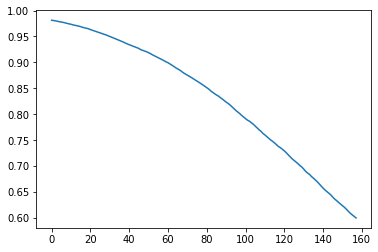

In [336]:
result_df['precision'].plot()

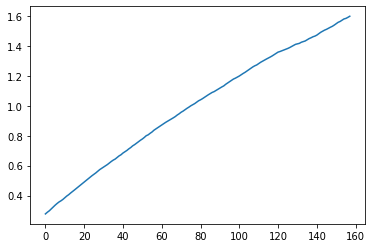

In [337]:
result_df['drift'].plot()

In [338]:
false_x = []
true_x = []

y_hat = business_model.predict(testset)

inx = 0
for yt,yp in zip(test_y,y_hat):
    if yt == yp:
        true_x.append(np.append(testset[inx],yt))
    else:
        false_x.append(np.append(testset[inx],yt))
    inx = inx + 1

true_x = np.asarray(true_x)
false_x = np.asarray(false_x)

In [339]:
false_x.shape

(111, 11)

In [349]:
import statsmodels.api as sm

def ppm_build(scale = 10.0,epoch =1000):
    scores = []
    drifts = []

    base = base_score[0]*100
    perf = np.random.normal(loc=base, scale=scale, size=epoch) 
    perf = np.asarray([c if c < base else base*2 - c for c in perf]) /100
    for i in range(epoch):
        tx = true_x[np.random.choice(true_x.shape[0], int((perf[i] * false_x.shape[0]) /(1 - perf[i])), replace=True),:]
        fx = false_x #np.random.permutation(false_x)[0:np.random.randint(1,false_x.shape[0],1)[0]]
        #fx = np.random.permutation(false_x)[0:np.random.randint(1,false_x.shape[0],1)[0]]
        #tx = true_x[np.random.choice(true_x.shape[0], fx.shape[0] * ratio, replace=True)[0:np.random.randint(1,fx.shape[0] * ratio,1)[0]],:]
        ffx = np.concatenate((tx,fx))
        np.random.shuffle(ffx)
        tx = ffx[:,0:10]
        ty = ffx[:,10]
        f1 = precision_recall_fscore_support(ty, business_model.predict(tx),average='binary')
        #x_ref2 = np.random.permutation(x_ref)[0:tx.shape[0]]
        #drift = __ks_drift(trainset[np.random.choice(trainset.shape[0],tx.shape[0], replace=False),:],tx)
        drift = __ks_drift(trainset,tx)
        scores.append(f1[0])
        drifts.append(drift[:,0])
        print(f"\r{i+1}/{epoch} precision:{f1[0]:.4f} drift:{drift[0,0]:.4f}", end="", flush=True)

    plt.hist(scores, bins = 100)
    plt.show()

    model = sm.OLS(scores, drifts).fit()
    print('Model R^2:',model.rsquared)
    print(model.summary())
    return model

1000/1000 precision:0.9108 drift:-0.0731

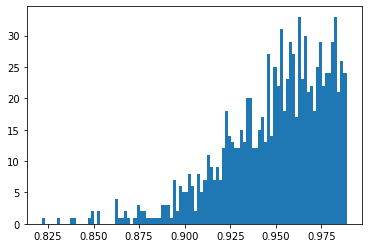

Model R^2: 0.7776943747173957
                                 OLS Regression Results                                
Dep. Variable:                      y   R-squared (uncentered):                   0.778
Model:                            OLS   Adj. R-squared (uncentered):              0.775
Method:                 Least Squares   F-statistic:                              346.3
Date:                Sat, 12 Nov 2022   Prob (F-statistic):                   5.15e-315
Time:                        15:21:24   Log-Likelihood:                         -616.12
No. Observations:                1000   AIC:                                      1252.
Df Residuals:                     990   BIC:                                      1301.
Df Model:                          10                                                  
Covariance Type:            nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------

In [350]:
ppmodel = ppm_build(scale = 5,epoch =1000)

In [351]:
from sklearn.metrics import r2_score

def test1(model2):
    result = {}
    result['precision'] = []
    result['predicted'] = []
    window_size = 100000
    step = 5000
    predicted = 0
    batch = math.ceil((X2.shape[0]-window_size)/step)
    for i in range(batch):
        ux = X2[i*step:i*step+window_size]
        uy = Y2[i*step:i*step+window_size]
        f1 = precision_recall_fscore_support(uy, business_model.predict(ux),average='binary')

        drift = __ks_drift(trainset,ux)
        precision = f1[0]
        predicted1 = model2.predict(drift[:,0])[0]
        if abs(predicted1-predicted) > 0.1 and predicted > 0:
            predicted1 = predicted
        result['precision'].append(precision)
        result['predicted'].append(predicted1)
        print(f"\r{i+1}/{batch} precision:{precision:.4f} predicted:{predicted1:.4f}", end="", flush=True)
        predicted = predicted1

    R2 = r2_score(result['precision'],result['predicted'])
    print('')
    print('R2:',R2)
    result_df = pd.DataFrame(result)
    result_df.plot()
    plt.show()
    return R2, result_df

158/158 precision:0.5993 predicted:1.0109
R2: -9.779809469743762


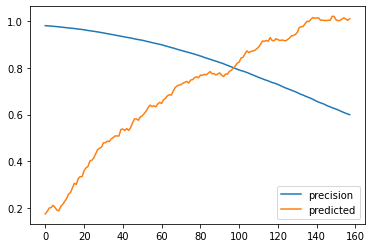

In [352]:
R2, result_df = test1(ppmodel)